# 3. 细胞分割教程

从加载样本肺癌数据集到分割单个细胞并将它们分类为不同细胞类型的完整工作流程。

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


WSI: ../data/lung_carcinoma.ndpi
Reader: openslide
Dimensions: 15616×16384 (h×w), 8 Pyramids
Pixel physical size: 0.22731405710129116 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1817, 1906)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
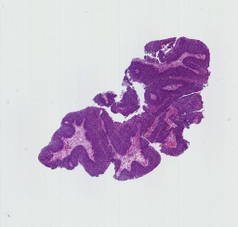

In [1]:
from wsidata import open_wsi

wsi = open_wsi("../data/lung_carcinoma.ndpi")
wsi

许多全切片图像（WSI）太大，无法放入 CPU/GPU 内存以运行推理。通常，需要将 WSI 分块以便处理。

为了提高细胞分割质量，强烈建议创建重叠的瓦片。

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:108: UserWarning: Key `tissues` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:108: UserWarning: Key `tiles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


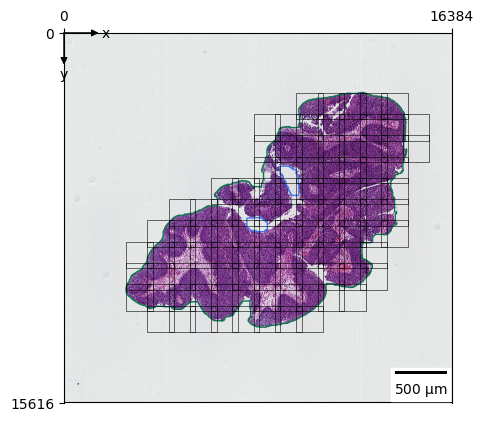

In [8]:
import lazyslide as zs

zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 512, overlap=0.2, background_fraction=0.95, mpp=0.5)
zs.pl.tiles(wsi, linewidth=0.4)

上图显示了用于细胞分割的瓦片。每个矩形代表一个 512x512 像素的瓦片，分辨率为 0.5 MPP。请注意，瓦片聚焦于富含组织的区域，同时避开空背景区域。

## 3.1 细胞分割

现在使用 InstanSeg 进行实际的细胞分割。这个深度学习模型将：

1. 检测每个组织瓦片中的单个细胞
2. 生成精确的细胞边界作为多边形形状
3. 处理重叠的细胞和复杂的组织结构

batch_size=32 参数控制同时处理的瓦片数量 - 根据您可用的 GPU 内存调整此参数。

In [6]:
zs.seg.cells(wsi, batch_size=32, model_file="../models/instanseg_v0_1_0.pt")

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/lazyslide/segmentation/_cell.py:72: UserWarning: To optimize the performance of Instanseg model, the tile size should be 512x512 and the mpp should be 0.5. Current tile size is 560x560 with 0.5 mpp.
  warnings.warn(


/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: >

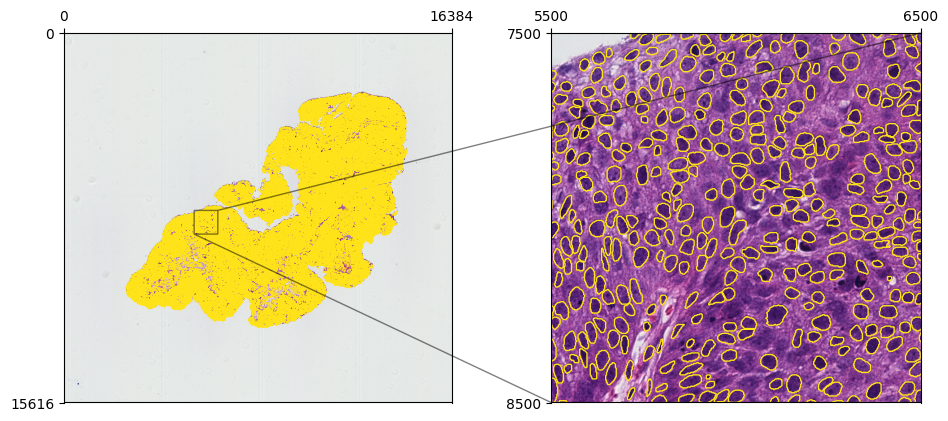

In [7]:
v = zs.pl.WSIViewer(wsi)
v.add_image()
v.add_polygons("cells", linewidth=1, fill=False)
v.add_zoom(5500, 6500, 7500, 8500)
v.show()

---

## 3.2 细胞类型分类


在分割单个细胞后，可以将它们分类为不同的细胞类型。这一步使用一个专门模型进行分析：

1. 细胞形态
2. 细胞背景
3. 染色特征

In [11]:
zs.seg.cell_types(wsi, model="nulite", batch_size=32, device="cuda:1", model_path="../models/NuLite_H_jit.pt")

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [12]:
v = zs.pl.WSIViewer(wsi)
v.add_image()
v.add_polygons("cell_types", color_by="class")

现在创建一个颜色编码的可视化，其中每种细胞类型都显示为不同的颜色。

<Axes: >

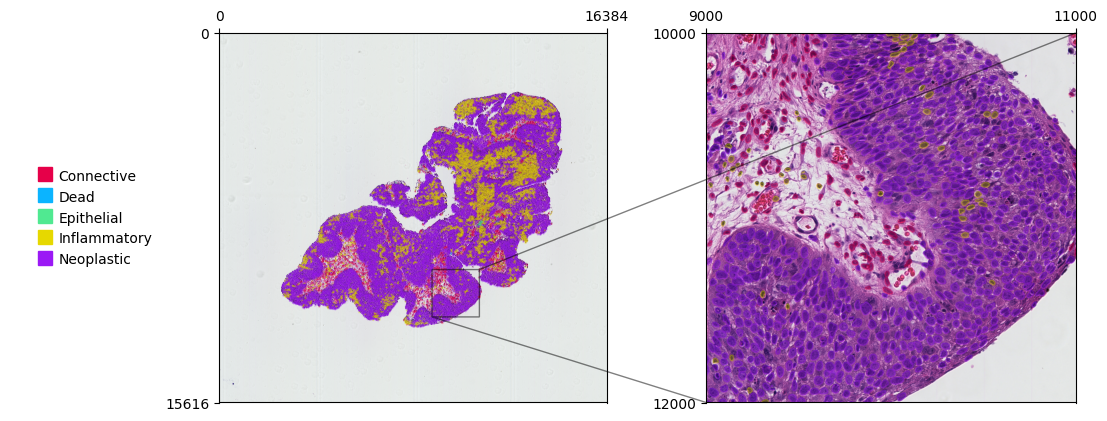

In [13]:
v.add_zoom(9000, 11000, 10000, 12000, cache=False)
v.show()